In [1]:
#https://www.mlflow.org/docs/latest/tutorials-and-examples/tutorial.html
#https://pedro-munoz.tech/how-to-setup-mlflow-in-production/
import os
import warnings
import sys

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import git

import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

sys.path.append('../')

In [2]:
#tracking
mlflow.set_tracking_uri("http://127.0.0.1:5000/")

In [3]:
# mlflow server --backend-store-uri 'sqlite:///mlflow.db' --artifacts-destination mlflow/artifacts_root --serve-artifacts

In [4]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [5]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

In [6]:
def savefig(rmse, mae, r2, artifact_path):
    df = pd.DataFrame()
    df['mae'] = [mae.round(3)]
    df['rmse'] = [rmse.round(3)]
    df['r2'] = [r2.round(3)]

    fig,ax = render_mpl_table(df, header_columns=0, col_width=2.0)
    fig.savefig(artifact_path+"/metrics.png")  

In [7]:
def get_commit_version():
    repo = git.Repo(search_parent_directories=True)
    return repo.head.object.hexsha

In [8]:
warnings.filterwarnings("ignore")
np.random.seed(40)

data = pd.read_csv("data/winequality-red.csv", sep=";")

# Split the data into training and test sets. (0.75, 0.25) split.
train, test = train_test_split(data)

# The predicted column is "quality" which is a scalar from [3, 9]
train_x = train.drop(["quality"], axis=1)
test_x = test.drop(["quality"], axis=1)
train_y = train[["quality"]]
test_y = test[["quality"]]

In [9]:
alpha = 0.5
l1_ratio = .6
run_name = 'Tutorial MLFlow'
description = 'Exemplo'
experiment_id = 0

Elasticnet model (alpha=0.500000, l1_ratio=0.600000):
  RMSE: 0.8097394716266468
  MAE: 0.6442565454817458
  R2: 0.0709815282346341


Registered model 'ElasticnetWineModel' already exists. Creating a new version of this model...
2022/09/30 09:56:08 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: ElasticnetWineModel, version 3
Created version '3' of model 'ElasticnetWineModel'.


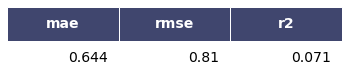

In [10]:
artifact_path = "artifacts"
with mlflow.start_run(run_name=run_name, experiment_id = experiment_id, description=description, tags={"mlflow.source.git.commit": get_commit_version()}):
    lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    lr.fit(train_x, train_y)

    predicted_qualities = lr.predict(test_x)

    (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

    print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    mlflow.log_param("alpha", alpha)
    mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)

    test_x.to_csv(artifact_path+"/test.csv")
    train_x.to_csv(artifact_path+"/train.csv")

    savefig(rmse,mae,r2, artifact_path)

    mlflow.log_artifact(artifact_path+"/test.csv", artifact_path="data")
    mlflow.log_artifact(artifact_path+"/train.csv", artifact_path="data")
    mlflow.log_artifact(artifact_path+"/metrics.png", artifact_path="images")

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    # Model registry does not work with file store
    if tracking_url_type_store != "file":

        # Register the model
        # There are other ways to use the Model Registry, which depends on the use case,
        # please refer to the doc for more information:
        # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        mlflow.sklearn.log_model(lr, "model", registered_model_name="ElasticnetWineModel")
        # model_info = mlflow.sklearn.log_model(lr, "model")
    else:
        mlflow.sklearn.log_model(lr, "model")

### Logged Model

In [11]:
logged_model = 'runs:/6946a48b73f9404aaf1378229a45309d/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
y_predict = loaded_model.predict(pd.DataFrame(test_x))
(rmse, mae, r2) = eval_metrics(test_y, y_predict)
print(f'RMSE: {rmse:.3f} | MAE: {mae:.3f} | R2: {r2:.3f}')

RMSE: 0.810 | MAE: 0.644 | R2: 0.071


### Stage

In [13]:
model_name = "ElasticnetWineModel"
stage = "Production"
# stage = "Staging"
loaded_model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{stage}")
y_predict = loaded_model.predict(pd.DataFrame(test_x))
(rmse, mae, r2) = eval_metrics(test_y, y_predict)
print(f'Stage: {stage} | RMSE: {rmse:.3f} | MAE: {mae:.3f} | R2: {r2:.3f}')

Stage: Production | RMSE: 0.810 | MAE: 0.644 | R2: 0.071


### Version

In [14]:
model_name = "ElasticnetWineModel"
# version = "1"
version = "2"
loaded_model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{version}")
y_predict = loaded_model.predict(pd.DataFrame(test_x))
(rmse, mae, r2) = eval_metrics(test_y, y_predict)
print(f'Version: {version} | RMSE: {rmse:.3f} | MAE: {mae:.3f} | R2: {r2:.3f}')

Version: 2 | RMSE: 0.810 | MAE: 0.644 | R2: 0.071
